In [6]:
library(ggplot2)
library(devtools)
install_github('dereksonderegger/STA578')

Installing STA578
'/Library/Frameworks/R.framework/Resources/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore CMD INSTALL  \
  '/private/var/folders/h9/sy3k4xgs0qgg9n6prlk_fj2c0000gn/T/RtmprpyWBB/devtools1bbc1efe1844/dereksonderegger-STA578-ad1cc15'  \
  --library='/Library/Frameworks/R.framework/Versions/3.2/Resources/library'  \
  --install-tests 

Reloading installed STA578


In [8]:
library(STA578)

Question 1
----------

In [9]:
my.rbeta = function(n, a=3, b=2) {
    rand.sample = c()
    max.density = dbeta(qbeta(0.5, a, b), a, b)
    while (length(rand.sample) < n) {
        x = runif(1, min=0, max=1)
        y = runif(1, min=0, max=max.density)
        if (dbeta(x, a, b) > y) {
            rand.sample = c(rand.sample, c(x))
        }
    }
    return(rand.sample)
}


stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


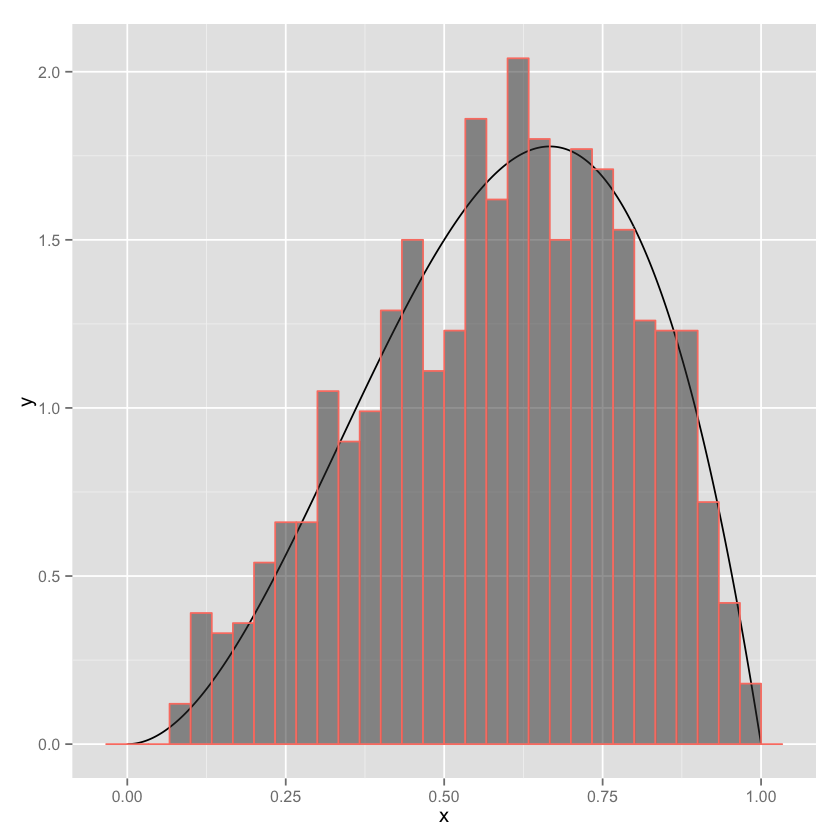

In [10]:
x = seq(0, 1, length=1001)
density.data =  data.frame( x = x, y=dbeta(x, 3,2) )
density.plot =  ggplot(density.data, aes(x=x, y=y)) + geom_line()
my.samples =  my.rbeta(1000, 3, 2)

density.plot + geom_histogram(data=data.frame(x=my.samples),
aes(y=..density..),
alpha=.5, color='salmon')

Question 2
---------

In [11]:
drayleigh = function(x, scale=2) {
    if ( scale < 0 ) {
        warning("NaNs produced")
        return(NaN)
    }
    #What to do with a vector containing a negative...?
    if ( any(x < 0 )) {
        result = 0
    } else {
        e.exp = exp(1)^((-x^2)/(2*(scale^2)))
        result = (x/(scale^2))*e.exp 
    }
    return(result)
}

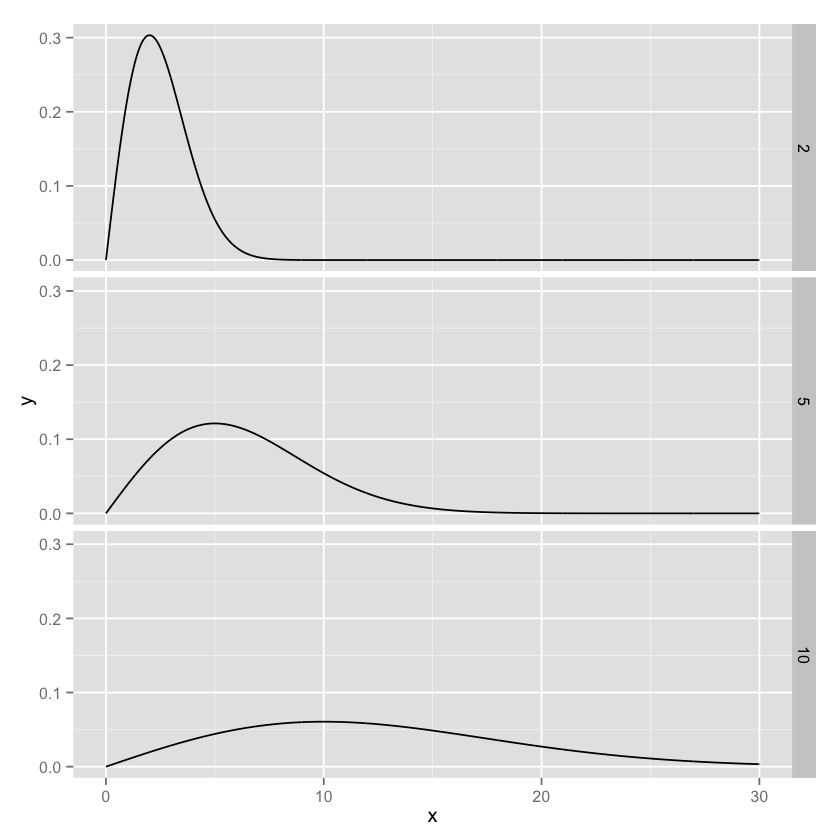

In [12]:
x = seq(0, 30, length=1001)
density.data = data.frame( x = x, 
                          y=drayleigh(x, 2), 
                          scale=2 )
for ( scale in c(5, 10) ) {
    density.data = rbind(density.data, data.frame( x = x, 
                              y=drayleigh(x, scale), 
                              scale=scale ))
    
}
ggplot(density.data, aes(x, y=y)) + geom_line() + facet_grid(scale ~.)

[1] 3


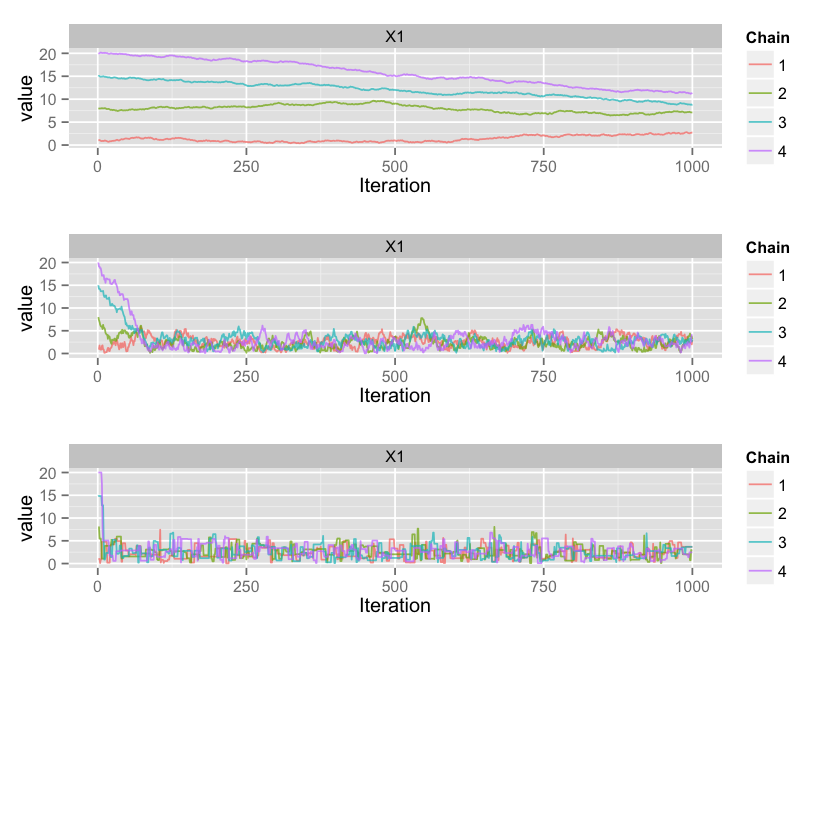

In [13]:
chains = vector("list",3)
steps = c(0.1, 1, 10)
for(i in 1:3) {
    chains[[i]]= mMCMC(drayleigh, list(1,8,15,20),
            rprop=function(x){ return(x+runif(1,-steps[i],steps[i])) },
            N=1000, 
            num.chains=4)
    
}
multiplot(trace_plot(chains[[1]]), 
          trace_plot(chains[[2]]),
          trace_plot(chains[[3]]), 
          n_cols=3)

The convergence here is poor with a step size of 0.1 is poor. We are looking for the chains to be essentially on top of each other. This would indicate that the distributions of the chains are relatively similar. In other words we want to B (the betweeen variance) to be roughly equal to W ( the within variance) B is much larger here suggesting the chains hvae not converged and are therefore not simulating the distribution well. We can also us the `Gelman` function to asses the convergence.

In [14]:
Gelman(chains[[1]])

,Parameter,W,B,sigma2.hat,R.hat,n.eff
1,X1,2.906295,37872.89,40.77628,3.745708,4.306646


If in fact B and W were similar, R hat would be close to 1, it is not so the view that the chains have not converged is reinforced.

The step size of 1 looks much better, with a fairly large range of starting values the chains converge relatively quickly. Likewise the R hat is very close to 1.

In [15]:
Gelman(chains[[2]])

,Parameter,W,B,sigma2.hat,R.hat,n.eff
1,X1,4.607848,161.9674,4.765208,1.016932,117.6831


The R hat value for a step size of 10 is low, however many of the steps get stuck in one place and many values are rejected. It seems to be making forays into places where values are rejected more frequently than with a step size distribution of 10.

In [16]:
Gelman(chains[[3]])

,Parameter,W,B,sigma2.hat,R.hat,n.eff
1,X1,2.70968,43.29473,2.750265,1.007461,254.097


[1] 3


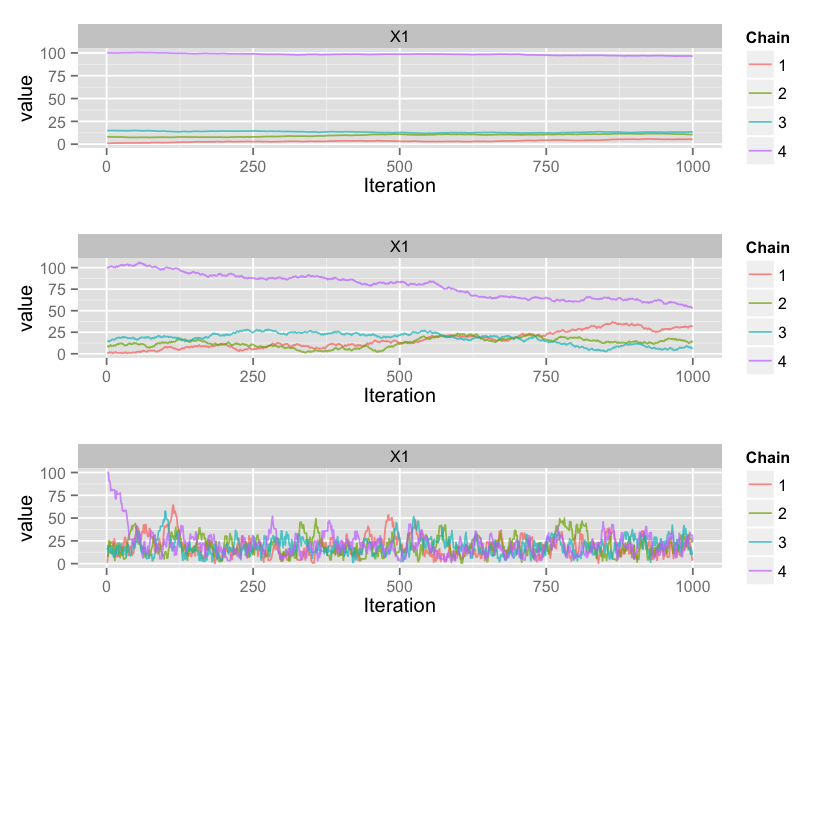

In [17]:
drayleigh_15 = function(x) {
    return(drayleigh(x, 15))
}

chains_15 = vector("list",3)
for(i in 1:3) {
    chains_15[[i]]= mMCMC(drayleigh_15, list(1,8,15,100),
            rprop=function(x){ return(x+runif(1,-steps[i],steps[i])) },
            N=1000, 
            num.chains=4)
    
}
multiplot(trace_plot(chains_15[[1]]), 
          trace_plot(chains_15[[2]]),
          trace_plot(chains_15[[3]]), 
          n_cols=3)

Here we can see that we do not start getting good results until the width of the proposal distribution is 10. This indicates that a distribution with more variation will need a larger step size in order to be able to efficiently explore the space. This is illsutrated in the first plot where the chains never seem to move from their starting position. 